<a href="https://colab.research.google.com/github/A23929/MDSC-302-Assignments/blob/main/22237_MDSC_302_Assignment_TransferLearning_Resnet_Hymenoptera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from google.colab import files
import pandas as pd
import torch
from torch.utils.data import Dataset,random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aniruddhapadmanaban","key":"f9fdfef7b2009572f9a4768f540991fd"}'}

In [3]:
! pip install -q kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

400 - Bad Request - Unrecognized DatasetFileTypeGroup enum value


In [7]:
! kaggle datasets download thedatasith/hymenoptera

 79% 36.0M/45.6M [00:00<00:00, 131MB/s]
100% 45.6M/45.6M [00:00<00:00, 119MB/s]


In [8]:
# ! mkdir thedatasith/hymenoptera

In [9]:
! unzip /content/hymenoptera.zip

Archive:  /content/hymenoptera.zip
  inflating: README.md               
  inflating: cover.jpg               
  inflating: hymenoptera/train/ants/0013035.jpg  
  inflating: hymenoptera/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera/train/ants/1473187633_63ccaacea6.jpg  
  inflating: hymenoptera/train/ants/148715752_302c84f5a4.jpg  
  inflatin

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


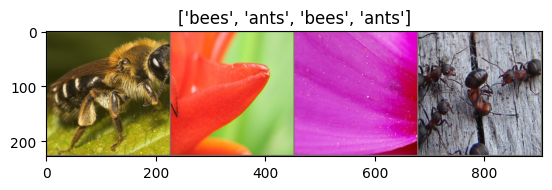

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, val_losses, train_accs, val_accs

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
model_ft, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.7545 Acc: 0.6393
val Loss: 0.2161 Acc: 0.9281

Epoch 1/14
----------
train Loss: 0.4917 Acc: 0.7951
val Loss: 0.3381 Acc: 0.8431

Epoch 2/14
----------
train Loss: 0.5699 Acc: 0.7869
val Loss: 0.3294 Acc: 0.8889

Epoch 3/14
----------
train Loss: 0.3961 Acc: 0.8361
val Loss: 0.1744 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.4174 Acc: 0.8197
val Loss: 0.2381 Acc: 0.9085

Epoch 5/14
----------
train Loss: 0.5052 Acc: 0.7992
val Loss: 0.2361 Acc: 0.9216

Epoch 6/14
----------
train Loss: 0.3416 Acc: 0.8402
val Loss: 0.2701 Acc: 0.9216

Epoch 7/14
----------
train Loss: 0.3842 Acc: 0.8443
val Loss: 0.2428 Acc: 0.9216

Epoch 8/14
----------
train Loss: 0.2646 Acc: 0.8893
val Loss: 0.2498 Acc: 0.9150

Epoch 9/14
----------
train Loss: 0.3541 Acc: 0.8238
val Loss: 0.2534 Acc: 0.9412

Epoch 10/14
----------
train Loss: 0.2538 Acc: 0.8811
val Loss: 0.2357 Acc: 0.9412

Epoch 11/14
----------
train Loss: 0.2276 Acc: 0.9057
val Loss: 0.2224 Acc: 0.9412

Epoch 12/14
----------
t

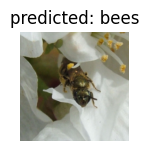

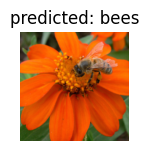

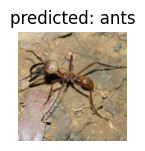

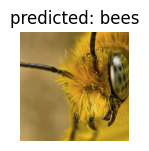

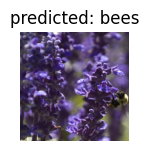

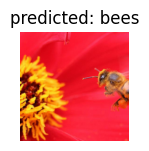

In [28]:
visualize_model(model_ft)

In [29]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [31]:
model_conv, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.4701 Acc: 0.8074
val Loss: 0.2145 Acc: 0.9281

Epoch 1/14
----------
train Loss: 0.4462 Acc: 0.7910
val Loss: 0.1636 Acc: 0.9542

Epoch 2/14
----------
train Loss: 0.5511 Acc: 0.7623
val Loss: 0.1703 Acc: 0.9542

Epoch 3/14
----------
train Loss: 0.7347 Acc: 0.7254
val Loss: 0.2890 Acc: 0.8889

Epoch 4/14
----------
train Loss: 0.4128 Acc: 0.8361
val Loss: 0.1807 Acc: 0.9477

Epoch 5/14
----------
train Loss: 0.5090 Acc: 0.7869
val Loss: 0.2537 Acc: 0.9150

Epoch 6/14
----------
train Loss: 0.3620 Acc: 0.8402
val Loss: 0.1900 Acc: 0.9608

Epoch 7/14
----------
train Loss: 0.2990 Acc: 0.8525
val Loss: 0.1978 Acc: 0.9477

Epoch 8/14
----------
train Loss: 0.2847 Acc: 0.8730
val Loss: 0.1811 Acc: 0.9477

Epoch 9/14
----------
train Loss: 0.4152 Acc: 0.8156
val Loss: 0.1790 Acc: 0.9412

Epoch 10/14
----------
train Loss: 0.3671 Acc: 0.8197
val Loss: 0.2028 Acc: 0.9346

Epoch 11/14
----------
train Loss: 0.3641 Acc: 0.8402
val Loss: 0.2154 Acc: 0.9281

Ep

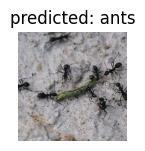

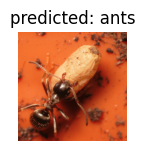

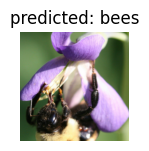

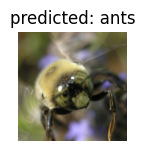

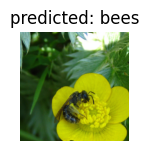

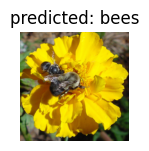

In [32]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [33]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

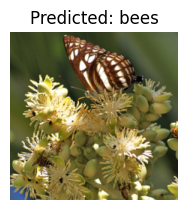

In [34]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

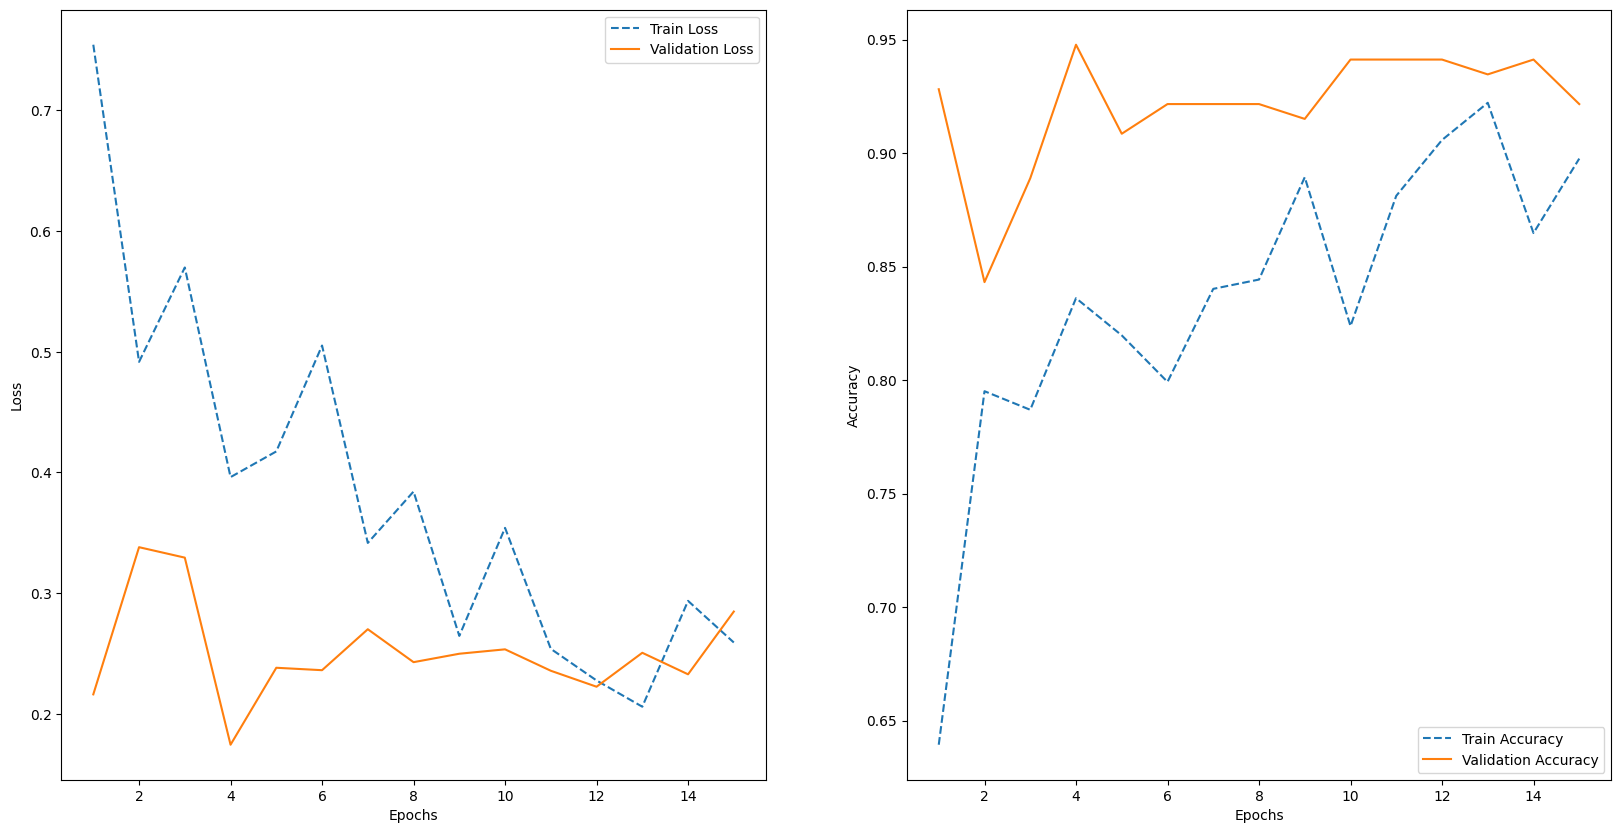

In [35]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist, label='Train Loss',linestyle = "dashed")
plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Plot training and validation accuracy curves
plt.subplot(1, 2, 2)
import numpy as np
train_acc = [x.item() for x in train_acc_hist]
val_acc = [x.item() for x in val_acc_hist]
plt.plot(range(1, len(train_acc_hist) + 1), train_acc, label='Train Accuracy',linestyle = "dashed")
plt.plot(range(1, len(val_acc_hist) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
